In [35]:
import pandas as pd
import requests
import plotly.graph_objects as go
import numpy as np
import GMX_data as gmx
import plotly.io as pio
pio.renderers.default = "notebook"

浮动币 ： ['UNI', 'LINK', 'ETH', 'WBTC']

In [2]:
symbol = gmx.get_token()
actions = gmx.get_actions()
end_day = '2023080100'

获取数据

In [3]:
glp = gmx.get_glp(end_day)
fees = gmx.get_fee(end_day)
prc = gmx.get_fast_price(symbol,end_day,token_list = ['ETH',"WBTC"])
hedge_ratio = [0.3,0.7]

In [4]:

  # 转换精度
  data = pd.merge(glp,fees,on=['id','time'])
  data = pd.merge(data,prc['ETH'][['time','value.eth']],on=['time'])
  data = pd.merge(data,prc['WBTC'][['time','value.wbtc']],on=['time'])
  data.sort_values('time',inplace=True)
  data['margin'] = data['margin'].astype(float) / 10**30
  data['marginAndLiquidation'] = data['marginAndLiquidation'].astype(float) / 10**30
  data['swap'] = data['swap'].astype(float) / 10**30
  data['mint'] = data['mint'].astype(float) / 10**30
  data['burn'] = data['burn'].astype(float) / 10**30
  data['total'] = data['marginAndLiquidation'] + data['swap'] + data['mint'] + data['burn']
  data['aumInUsdg'] = data['aumInUsdg'].astype(float) / 10**18
  data['glpSupply'] = data['glpSupply'].astype(float) / 10**18
  data['liquidation'] = data['marginAndLiquidation'] - data['margin']
  data.reset_index(inplace=True,drop=True)


模拟对冲

In [31]:

# 设置仓位和对冲比率
v0 = 10000
btc_v0 = v0 / data['value.wbtc'][0]  # 投入gmx的btc
vwbtc = btc_v0 * data['value.wbtc'][0] * 0.8

# 计算买的数量
result = pd.DataFrame()
result['Date'] = data['time']
my_glp = v0 / data['price'][0]

# 计算合约开仓的btc数量
my_btc = vwbtc / data['value.wbtc'][0]
btc_open = data['value.wbtc'][0]

# 计算资产池的价值

result['glp_value'] = data['price'] * my_glp
# 该时刻能换回的wbtc数量
result['glp_to_wbtc'] = my_glp * data['price'] / data['value.wbtc']
result['glp_to_wbtc'] = result['glp_to_wbtc'] - btc_v0
# 合约PnL
result['wbtc_pnl'] = data.apply(lambda x: gmx.calc_bi_pnl(btc_open, x['value.wbtc'],1,vwbtc),axis=1)
result['total_dx'] = result['glp_to_wbtc'] + result['wbtc_pnl']

result['asset_pnl'] = result['total_dx'] * data['value.wbtc']
# dividend
result['ratio'] = my_glp / data['glpSupply']
result['div'] = data['total'] * result['ratio']
# ret是累计分红 + 资产池相对于初始状态变化
result['ret'] = result['div'].cumsum() + result['asset_pnl']

result = result.fillna(0)


In [43]:
result
'''变量解释：
glp_to_wbtc:当前时刻能换回wbtc比最初投入wbtc的差值;
wbtc_pnl:永续合约的pnl;
total_dx:两边总共增加或减少的btc个数;
'''

,Date,glp_value,glp_to_wbtc,wbtc_pnl,total_dx,asset_pnl,ratio,div,ret,nav,max,drawdown
0,2022-05-16 11:00:00,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000051,0.116444,0.116444,1.000006,1.000006,0.000000
1,2022-05-16 12:00:00,10000.001939,0.000648,-0.000519,0.000130,3.877021,0.000051,0.234967,4.228433,1.000235,1.000235,0.000000
2,2022-05-16 13:00:00,9952.717366,0.003365,-0.003974,-0.000609,-17.972690,0.000050,1.035604,-16.585675,0.999079,1.000235,-0.001156
3,2022-05-16 14:00:00,9962.495347,0.003879,-0.004121,-0.000242,-7.129647,0.000050,0.895029,-4.847603,0.999731,1.000235,-0.000504
4,2022-05-16 15:00:00,9974.579056,0.002432,-0.002632,-0.000199,-5.914604,0.000050,0.699247,-2.933313,0.999837,1.000235,-0.000398
...,...,...,...,...,...,...,...,...,...,...,...,...
9992,2023-07-06 23:00:00,10959.156100,0.032461,-0.000310,0.032151,961.476808,0.000022,0.558712,4714.331222,1.261907,1.271561,-0.007592
9993,2023-07-07 00:00:00,10965.975497,0.030776,0.001085,0.031861,957.819188,0.000022,0.768161,4711.441762,1.261747,1.271561,-0.007718
9994,2023-07-07 01:00:00,10979.598208,0.030827,0.001378,0.032205,969.227470,0.000022,0.240588,4723.090633,1.262394,1.271561,-0.007209
9995,2023-07-07 02:00:00,10984.095052,0.030872,0.001454,0.032326,973.148896,0.000022,0.047046,4727.059106,1.262614,1.271561,-0.007036


<AxesSubplot:title={'center':'GMX PnL'}, xlabel='Date'>

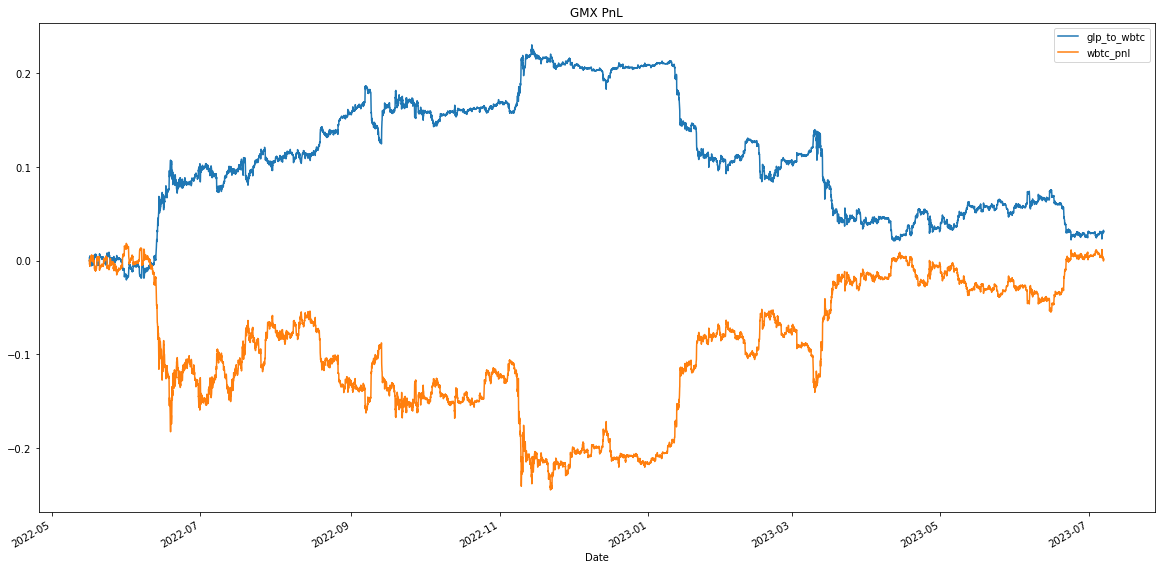

In [44]:
result.plot(x='Date',y=['glp_to_wbtc','wbtc_pnl'],figsize=(20,10),title='GMX PnL')

结果指标

In [42]:

# 计算最大回撤
result['nav'] = (result['ret'] / (v0 + vwbtc) + 1)
result['max'] = result['nav'].cummax()
result['drawdown'] = result['nav'] / result['max'] - 1
# 最大回撤时间段
max_drawdown_end = result['Date'].iloc[result['drawdown'].idxmin()]
# 年化收益率
apy = result['ret'].iloc[-1] / (v0 + vwbtc) * 365 / (result['Date'].iloc[-1] - result['Date'].iloc[0]).days
# 夏普比率,按每日收益率计算
result.set_index('Date',inplace=True)
sharpe = result['nav'].resample('D').last().pct_change().mean() / result['nav'].resample('D').last().pct_change().std() * np.sqrt(365)
result.reset_index(inplace=True)
# print result
print('apy: ', apy)
print('sharpe: ', sharpe)
print('max drawdown: ',result['drawdown'].min(),'end at: ', max_drawdown_end)
indicators = [apy,sharpe,result['drawdown'].min()]


# plot
plot_data = [go.Scatter(x=result['Date'], y=result['ret'] , name='ret'),\
        go.Scatter(x=result['Date'], y=result['div'].cumsum(), name='div'),\
        go.Scatter(x=result['Date'], y=result['glp_value'] - v0, name='glp_value'),\
        go.Scatter(x=result['Date'], y=result['asset_pnl'], name='asset_pnl'),\
        ]

layout = go.Layout(
        title='GLP',
        yaxis=dict(
                title='return',
        ),
        yaxis2=dict(
                title='dx',
                overlaying='y',
                side='right')
)

fig = go.Figure(data=plot_data, layout=layout)
fig.show()

apy:  0.23060664806426895
sharpe:  1.8692817593808386
max drawdown:  -0.07014242223013756 end at:  2022-11-09 21:00:00


In [ ]:
import json

token_list = ['USDC.e', 'USDT', 'UNI', 'LINK', 'DAI', 'ETH', 'WBTC','FRAX']
address_list = [x for x in symbol.index if symbol.loc[x,'data.symbol'] in token_list]
data = pd.DataFrame()
for address in address_list:
    query = f'''{{
    tokenStats(first: 10000, orderBy: timestamp, orderDirection: desc, where: {{ period: "hourly", timestamp_lt: 1800000000, timestamp_gt: 0, token: "{address}" }}) {{
        id
        token
        poolAmount
        poolAmountUsd
        usdgAmount
        reservedAmount
        reservedAmountUsd
        timestamp
        period
    }}
    }}
    '''
    url = 'https://subgraph.satsuma-prod.com/3b2ced13c8d9/gmx/gmx-arbitrum-stats/api'
    headers = {'Content-Type': 'application/json'}
    request_json = {'query': query}
    response = requests.post(url, headers=headers, data=json.dumps(request_json))
    response = response.json()
    if 'errors' in response:
        error_message = data['errors'][0]['message']
        raise Exception(f"GraphQL query failed: {error_message}")
    response = response['data']['tokenStats']
    response = pd.DataFrame(response)
    data = pd.concat([data,response],join = 'outer',axis = 0)


data['time'] = pd.to_datetime(data['timestamp'], unit='s')
data['token'] = data['token'].apply(lambda x: symbol.loc[x]['data.symbol'])
data['poolAmount'] = data['poolAmount'].astype(float) / 10**30
data['poolAmountUsd'] = data['poolAmountUsd'].astype(float) / 10**30
data['usdgAmount'] = data['usdgAmount'].astype(float) / 10**30
data['reservedAmount'] = data['reservedAmount'].astype(float) / 10**30
data['reservedAmountUsd'] = data['reservedAmountUsd'].astype(float) / 10**30
# 计算每个小时的各个币种的比例
# 取eth > 1的数据
cut_window = data[data['token'] == 'ETH'].copy()
data = data[data['time'] >= cut_window['time'].min()]
data['percentage'] = data['poolAmountUsd'] /data['time'].map(data.groupby('time')['poolAmountUsd'].sum())

In [ ]:
# 重组成一个表
compo_data = data.pivot(index = 'time',columns = 'token',values = 'percentage')
compo_data.fillna(0,inplace = True)
# 画柱状图
# compo_data.plot(kind = 'bar',stacked = True,figsize = (20,10),title = 'GMX pool composition')

In [ ]:
# 获得价格
prc = gmx.get_fast_price(symbol,end_day,['ETH',"WBTC","LINK","UNI"])

In [ ]:
for key,value in prc.items():
    temp = value.set_index('time')
    compo_data['value.' + key.lower()] = temp['value.' + key.lower()]
compo_data = compo_data.dropna()

In [ ]:
# 合成指数
# 每n个小时调整一次
v0 = 10000
n = 24
count = 0
ratio = compo_data.mean()[['WBTC','ETH','UNI','LINK']]
compo_value = (v0 * ratio).to_list()  / compo_data[['value.wbtc','value.eth','value.uni','value.link']].values[0]
index = (compo_value * compo_data[['value.wbtc','value.eth','value.uni','value.link']]).sum(axis = 1) + v0 * (1-ratio.sum())
compo_data['index'] = index
compo_data

token,DAI,ETH,FRAX,LINK,UNI,USDC.e,USDT,WBTC,value.wbtc,value.eth,value.uni,value.link,index
time,,,,,,,,,,,,,
2023-05-23 11:00:00,0.062581,0.286001,0.014672,0.005514,0.005547,0.426983,0.005004,0.193698,27342.027,1855.329,5.132,6.539,10000.000000
2023-05-23 12:00:00,0.062667,0.285717,0.014656,0.005534,0.005562,0.427357,0.005012,0.193495,27288.589,1852.1,5.128,6.539,9990.620554
2023-05-23 13:00:00,0.063106,0.286936,0.014790,0.000000,0.005599,0.430246,0.004963,0.194358,27239.843,1847.318,5.105,6.526,9978.903934
2023-05-23 14:00:00,0.000000,0.305368,0.015653,0.005918,0.005911,0.455369,0.005253,0.206528,27333.256,1857.309,5.116,6.562,10002.380516
2023-05-23 15:00:00,0.062605,0.286269,0.014773,0.005537,0.005540,0.426847,0.004927,0.193501,27326.94,1857.299,5.123,6.548,10001.801979
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01 19:00:00,0.067476,0.278361,0.000000,0.006396,0.006475,0.369387,0.015935,0.255970,30619.22,1922.77,5.539,6.428,10374.106926
2023-07-01 20:00:00,0.067635,0.280230,0.000000,0.006508,0.000000,0.372070,0.016040,0.257517,30584.63,1922.5,5.548,6.464,10371.292209
2023-07-01 21:00:00,0.065774,0.272474,0.021291,0.006299,0.006329,0.361840,0.015601,0.250391,30589.52,1922.85,5.539,6.431,10371.842006


In [ ]:
glp = gmx.get_glp(end_day)
glp = glp[(glp['time'] >= compo_data.index.min()) & (glp['time'] <= compo_data.index.max())]
glp.sort_values('time',inplace = True)
glp.set_index('time',inplace = True)


<AxesSubplot:title={'center':'GMX index vs GLP'}, xlabel='time'>

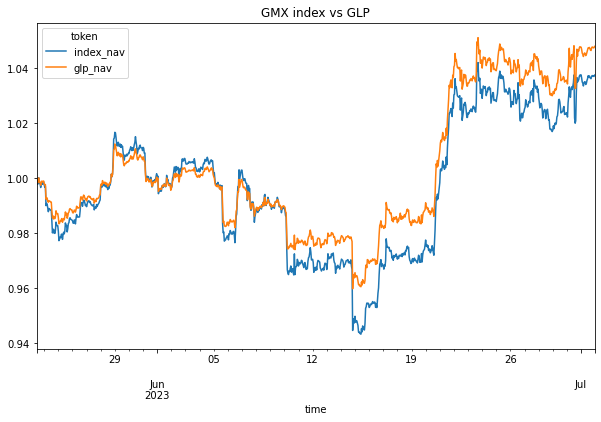

In [ ]:
compo_data['index_nav'] = compo_data['index'] / compo_data['index'].iloc[0]
glp['glp_nav'] = glp['price'] / glp['price'].iloc[0]
compo_data['glp_nav'] = glp['glp_nav']
# 画图，白色背景
compo_data[['index_nav','glp_nav']].plot(figsize = (10,6),title = 'GMX index vs GLP')

In [ ]:
import json

token_list = ['USDC.e', 'USDT', 'UNI', 'LINK', 'DAI', 'ETH', 'WBTC','FRAX']
address_list = [x for x in symbol.index if symbol.loc[x,'data.symbol'] in token_list]
data = pd.DataFrame()
for address in address_list:
    query = f'''{{
    tokenStats(first: 1000, orderBy: timestamp, orderDirection: desc, where: {{ period: "hourly", timestamp_lt: 1800000000, timestamp_gt: 0, token: "{address}" }}) {{
        id
        token
        poolAmount
        poolAmountUsd
        usdgAmount
        reservedAmount
        reservedAmountUsd
        timestamp
        period
    }}
    }}
    '''
    url = 'https://subgraph.satsuma-prod.com/3b2ced13c8d9/gmx/gmx-arbitrum-stats/api'
    headers = {'Content-Type': 'application/json'}
    request_json = {'query': query}
    response = requests.post(url, headers=headers, data=json.dumps(request_json))
    response = response.json()
    if 'errors' in response:
        error_message = data['errors'][0]['message']
        raise Exception(f"GraphQL query failed: {error_message}")
    response = response['data']['tokenStats']
    response = pd.DataFrame(response)
    data = pd.concat([data,response],join = 'outer',axis = 0)


data['time'] = pd.to_datetime(data['timestamp'], unit='s')
data['token'] = data['token'].apply(lambda x: symbol.loc[x]['data.symbol'])
data['poolAmount'] = data['poolAmount'].astype(float) / 10**30
data['poolAmountUsd'] = data['poolAmountUsd'].astype(float) / 10**30
data['usdgAmount'] = data['usdgAmount'].astype(float) / 10**30
data['reservedAmount'] = data['reservedAmount'].astype(float) / 10**30
data['reservedAmountUsd'] = data['reservedAmountUsd'].astype(float) / 10**30
# 计算每个小时的各个币种的比例
# 取eth > 1的数据
cut_window = data[data['token'] == 'ETH'].copy()
data = data[data['time'] >= cut_window['time'].min()]
data['percentage'] = data['poolAmountUsd'] /data['time'].map(data.groupby('time')['poolAmountUsd'].sum())